In [1]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

In [ ]:
!python -m spacy download en_core_web_lg

In [3]:
#gensim
import gensim
from gensim import corpora

In [ ]:
#Visualization

!pip install pyLDAvis

from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
#Data loading/ Data manipulation
!pip install jsonlines
import pandas as pd
import numpy as np
import jsonlines

In [ ]:
#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])


In [ ]:
#warning
import warnings
warnings.filterwarnings('ignore')

In [8]:
from google.colab import drive

In [9]:
#Resume Dataset
df = pd.read_csv("/content/drive/MyDrive/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[
    0:200,
]
data.head()

,ID,Resume_str,Resume_html,Category
2289,32318506,RDA Professional Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
2233,27884470,"DIRECTOR, VENDOR SERVICES AND COMPLIA...","<div class=""fontsize fontface vmargins hmargin...",BANKING
322,25857360,STAFF ASSISTANT Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
1656,13858219,ASSISTANT MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
422,27126818,HISTORY TEACHER Experience ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER


In [10]:
#Loading the spaCy model
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/content/drive/MyDrive/jz_skill_patterns.jsonl"

In [ ]:
#Entity Ruler
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

In [12]:
#Skills
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [13]:
#Cleaning Resume Text
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [14]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
2289,32318506,RDA Professional Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,rda professional summary dependable hardworkin...,[schedule]
2233,27884470,"DIRECTOR, VENDOR SERVICES AND COMPLIA...","<div class=""fontsize fontface vmargins hmargin...",BANKING,director vendor service compliance summary ext...,"[support, workflow, documentation, schedule, d..."
322,25857360,STAFF ASSISTANT Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,staff assistant professional summary highly or...,"[finance, support, schedule, material, account..."
1656,13858219,ASSISTANT MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,assistant manager summary general associate em...,[business]
422,27126818,HISTORY TEACHER Experience ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,history teacher experience history teacher 08 ...,"[framework, support, documentation, schedule, ..."


In [15]:
#Visualization
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [16]:
#Skills
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

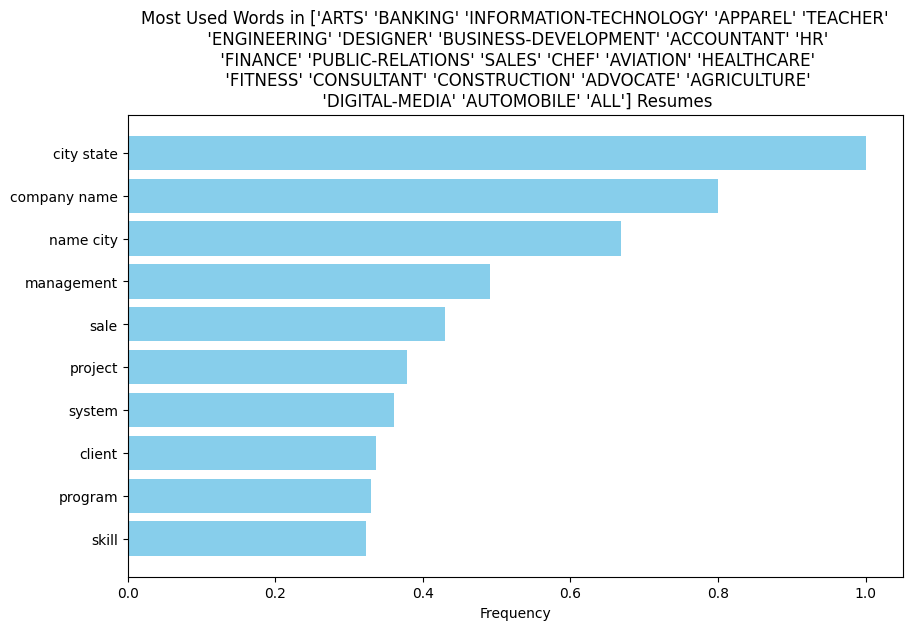

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Most Used Words
text = ""
for category in Job_cat:
    for i in data[data["Category"] == category]["Clean_Resume"].values:
        text += i + " "

# Generate WordCloud
wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,

)
wc.generate(text)

# Get most used words
most_used_words = wc.words_

# Create a horizontal bar chart
top_words = Counter(most_used_words).most_common(10)  # Display the top 10 words
words, frequencies = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.title(f'Most Used Words in {Job_cat} Resumes')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [18]:
#ENTITY RECOGNITION
sent = nlp(data["Resume_str"].iloc[20])
displacy.render(sent, style="ent", jupyter=True)


In [19]:
#Dependency Parsing
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [20]:
#Custom Entity Recognition
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

In [21]:
from IPython.display import HTML
import spacy
from spacy import displacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Resume as a string
input_resume = "Abid Ali Awan Data Scientist I am a certified data scientist professional, who loves building machine learning models and blogs about the latest AI technologies. I am currently testing AI Products at PEC-PITC, which later gets approved for human trials. abidaliawan@tutamail.com +923456855126 Islamabad, Pakistan abidaliawan.me WORK EXPERIENCE Data Scientist Pakistan Innovation and Testing Center - PEC 04/2021 - Present, Islamabad, Pakistan Redesigned data of engineers that were mostly scattered and unavailable. Designed dashboard and data analysis report to help higher management make better decisions. Accessibility of key information has created a new culture of making data-driven decisions. Contact: Ali Raza Asif - darkslayerraza10@gmail.com Data Scientist Freelancing/Kaggle 11/2020 - Present, Islamabad, Pakistan Engineered a healthcare system. Used machine learning to detect some of the common decisions. The project has paved the way for others to use new techniques to get better results. Participated in Kaggle machine learning competitions. Learned new techniques to get a better score and finally got to 1 percent rank. Researcher / Event Organizer CREDIT 02/2017 - 07/2017, Kuala Lumpur, Malaysia Marketing for newly build research lab. Organized technical events and successfully invited the multiple company's CEO for talks. Reduced the gap between industries and educational institutes. Research on new development in the IoT sector. Created research proposal for funding. Investigated the new communication protocol for IoT devices. Contact: Dr. Tan Chye Cheah - dr.chyecheah.t@apu.edu.my EDUCATION MSc in Technology Management Staffordshire University 11/2015 - 04/2017, Postgraduate with Distinction Challenges in Implementing IoT-enabled Smart cities in Malaysia. Bachelors Electrical Telecommunication Engineering COMSATS Institute of Information Technology, Islamabad 08/2010 - 01/2014, CGPA: 3.09 Networking Satellite communications Programming/ Matlab Telecommunication Engineering SKILLS Designing Leadership Media/Marketing R/Python SQL Tableau NLP Data Analysis Machine learning Deep learning Webapp/Cloud Feature Engineering Ensembling Time Series Technology Management ACHIEVEMENTS 98th Hungry Geese Simulation Competition (08/2021) 2nd in Covid-19 vaccinations around the world (07/2021) 8th in Automatic Speech Recognition in WOLOF (06/2021) Top 10 in WiDS Datathon. (03/2021) 40th / 622 in MagNet: Model the Geomagnetic Field Hosted by NOAA (02/2021) 18th in Rock, Paper, Scissors/Designing AI Agent Competition. (02/2021) PROJECTS Goodreads Profile Analysis WebApp (09/2021) Data Analysis Web Scraping XLM Interactive Visualization Contributed in orchest.io (08/2021) Testing and Debuging Technical Article Proposing new was to Improve ML pipelines World Vaccine Update System (06/2021) Used sqlite3 for database Automated system for daily update the Kaggle DB and Analysis Interactive dashboard mRNA-Vaccine-Degradation-Prediction (06/2021) Explore our dataset and then preprocessed sequence, structure, and predicted loop type features Train deep learning GRU model Trip Advisor Data Analysis/ML (04/2021) Preprocessing Data, Exploratory Data analysis, Word clouds. Feature Engineering, Text processing. BiLSTM Model for predicting rating, evaluation, model performance. Jane Street Market Prediction (03/2021) EDA, Feature Engineering, experimenting with hyperparameters. Ensembling: Resnet, NN Embeddings, TF Simple NN model. Using simple MLP pytorch model. Achievements/Tasks Achievements/Tasks Achievements/Tasks Thesis Courses"

# Function to process the input resume and display entities
def process_resume(resume_text):
    sent2 = nlp(resume_text)
    html = displacy.render(sent2, style="ent", options=options, page=True)
    display(HTML(html))

# Call the function with the initial resume text
process_resume(input_resume)

In [22]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.011*"system" + 0.007*"state" + 0.007*"company" + 0.007*"city" + 0.006*"management" + 0.006*"project" + 0.005*"support" + 0.005*"name" + 0.005*"information" + 0.004*"patient"'),
 (1,
  '0.012*"company" + 0.012*"customer" + 0.012*"state" + 0.012*"sale" + 0.010*"city" + 0.009*"management" + 0.008*"name" + 0.008*"service" + 0.007*"business" + 0.007*"account"'),
 (2,
  '0.011*"state" + 0.010*"company" + 0.010*"city" + 0.009*"management" + 0.008*"name" + 0.006*"program" + 0.006*"team" + 0.006*"employee" + 0.006*"new" + 0.006*"development"'),
 (3,
  '0.013*"student" + 0.009*"state" + 0.008*"city" + 0.007*"project" + 0.006*"education" + 0.005*"skill" + 0.005*"teacher" + 0.005*"school" + 0.005*"company" + 0.005*"name"')]

In [23]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.099219  0.010685       1        1  41.878659
2      0.044715 -0.073795       2        1  24.752643
0     -0.019288  0.095921       3        1  21.990192
3     -0.124647 -0.032811       4        1  11.378505, topic_info=           Term        Freq       Total Category  logprob  loglift
174     student  241.000000  241.000000  Default  30.0000  30.0000
444      system  573.000000  573.000000  Default  29.0000  29.0000
420        sale  717.000000  717.000000  Default  28.0000  28.0000
198     account  371.000000  371.000000  Default  27.0000  27.0000
480  accounting  223.000000  223.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
444      system   50.638740  573.081447   Topic4  -5.6413  -0.2529
673  technology   40.258988  186.076747   Topic4  -5.8707   0.6426
181        team   42.810591  555.254252   Topic4  -5.8092  -0.3892
57    developed   40.745695  253.139330   Topic4  -5.8587   0.3469
340  management   39.556278  931.137109   Topic4  -5.8883  -0.9852

[333 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
786       1  0.205304  academic
786       2  0.055992  academic
786       3  0.093320  academic
786       4  0.653240  academic
198       1  0.944643   account
...     ...       ...       ...
462       3  0.261333      work
462       4  0.130667      work
1371      2  0.879289     wrote
1371      4  0.109911     wrote
2334      2  0.945615      yoga

[614 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])